In [1]:
import re
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
data_path = "./data/"

# Analysis of characters dataset

In [3]:
#load characters data
chars = pd.read_csv(data_path + 'lotr_characters.csv')
chars.head()

,birth,death,gender,hair,height,name,race,realm,spouse
0,NaN,NaN,Female,NaN,NaN,Adanel,Men,NaN,Belemir
1,TA 2978,"February 26 ,3019",Male,Dark (book) Light brown (movie),NaN,Boromir,Men,NaN,NaN
2,NaN,"March ,3019",Male,NaN,NaN,Lagduf,Orcs,NaN,NaN
3,TA 280,TA 515,Male,NaN,NaN,Tarcil,Men,Arnor,Unnamed wife
4,NaN,NaN,Male,NaN,NaN,Fire-drake of Gondolin,Dragon,NaN,NaN


**Data Cleaning**

In [4]:
#map the races
race_mappings = {
    "Dragons" : "Dragon",
    "Dwarven" : "Dwarf",
    "Dwarves" : "Dwarf",
    "Eagles" : "Eagle",
    "Elves" : "Elf",
    "Hobbits" : "Hobbit",
    "Orcs" : "Orc",
    "Balrogs" : "Balrog"
}
chars['race'].replace(race_mappings, regex = True, inplace = True)
chars.head()

,birth,death,gender,hair,height,name,race,realm,spouse
0,NaN,NaN,Female,NaN,NaN,Adanel,Men,NaN,Belemir
1,TA 2978,"February 26 ,3019",Male,Dark (book) Light brown (movie),NaN,Boromir,Men,NaN,NaN
2,NaN,"March ,3019",Male,NaN,NaN,Lagduf,Orc,NaN,NaN
3,TA 280,TA 515,Male,NaN,NaN,Tarcil,Men,Arnor,Unnamed wife
4,NaN,NaN,Male,NaN,NaN,Fire-drake of Gondolin,Dragon,NaN,NaN


In [5]:
#get some stats about races with grouping
race_counts = chars.groupby('race').size().reset_index(name='Size')
top_races = race_counts.sort_values('Size', ascending = False).head(5)
top_races

,race,Size
23,Men,388
19,Hobbit,142
8,Elf,106
6,Dwarf,44
0,Ainur,24


In [6]:
#map the gender and get some stats
gender_mappings = {
    "Males" : "Male",
    "male" : "Male",
    "Most likely male" : "Male"
}
chars['gender'].replace(gender_mappings, inplace = True)
chars.loc[chars.gender.isna(), 'gender'] = 'Unknown'
gender_counts = chars.groupby('gender').size().reset_index(name='Size')
gender_counts.sort_values('Size', ascending = False)

,gender,Size
1,Male,633
2,Unknown,143
0,Female,135


In [7]:
#get some stats about races with grouping
male_race_counts = chars[(chars.gender == 'Male') & (chars.race.isin(top_races.race.values))].groupby('race').size().reset_index(name='Size')
male_race_counts.sort_values('Size', ascending = False)
#get some stats about races with grouping
female_race_counts = chars[(chars.gender == 'Female') & (chars.race.isin(top_races.race.values))].groupby('race').size().reset_index(name='Size')
female_race_counts.sort_values('Size', ascending = False)

all_genders = female_race_counts
all_genders['Male'] = male_race_counts.Size
all_genders['Female'] = female_race_counts.Size
all_genders.drop('Size', axis = 1, inplace=True)
all_genders

,race,Male,Female
0,Ainur,14,10
1,Dwarf,43,1
2,Elf,79,24
3,Hobbit,101,41
4,Men,335,51


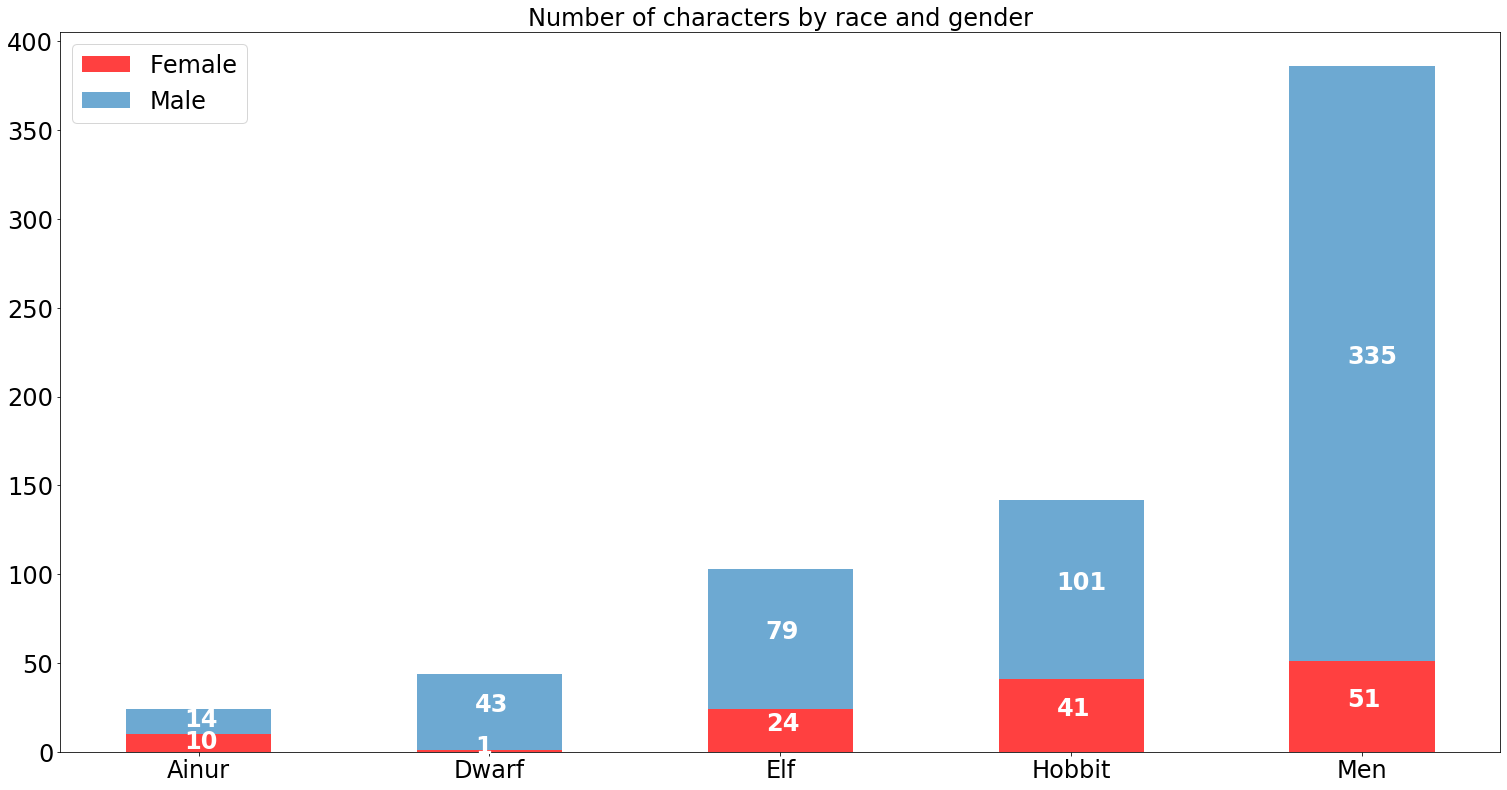

In [8]:
plt.rc('font', size=24)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

y_pos = np.arange(5)

r = all_genders.race.values
m = all_genders.Male.values
f = all_genders.Female.values

fig = plt.figure(figsize=(20,10))

width = 0.5

ax = fig.add_axes([0,0,1,1])
ax.bar(y_pos, f, width, color='#ff4040')
ax.bar(y_pos, m, width,bottom=f, color='#6da9d2')

ax.set_title('Number of characters by race and gender')

for i, v in enumerate(m):
    if i == 0:
        ax.text(i - .05, 14, str(v), color='white', fontweight='bold')
    else:
        ax.text(i - .05, f[i] + v / 2, str(v), color='white', fontweight='bold')
        
for i, v in enumerate(f):
    if i >= 2:
        ax.text(i - .05, v  / 2, str(v), color='white', fontweight='bold')
    elif i == 0:
        ax.text(i - .05, 2, str(v), color='white', fontweight='bold')
    else:
        ax.text(i - .05, -1, str(v), color='white', fontweight='bold')
plt.xticks(y_pos, r)
ax.legend(labels=['Female', 'Male'])

plt.savefig(os.path.join('race_gender.png'), dpi=300, format='png', bbox_inches='tight')

plt.show()

In [9]:
#same for hair color
hair_counts = chars.groupby('hair').size().reset_index(name='size')
hair_counts.sort_values('size', ascending = False).head()

,hair,size
26,Dark,29
45,Golden,21
5,Black,12
16,Brown,6
60,None,5


In [10]:
#and realm...
realm_counts = chars.groupby('realm').size().reset_index(name='size')
realm_counts.sort_values('size', ascending = False).head()

,realm,size
22,Gondor,33
47,Númenor,28
56,Rohan,20
7,Arthedain,9
4,Arnor,7


*Date for birth and death are not categorical. In order to get some insight, we are categorizing them based on the era*

In [11]:
timeline_mappings = {
    "Third Age" : "TA",
    "Second Age" : "SA",
    "First Age" : "FA",
    "Years of the Trees" : "YT",
    "Fourth Age" : "FO"
}
def birth_death(d, cname):
    d[cname].replace(timeline_mappings, regex = True, inplace = True)
    d.loc[d[cname].str.startswith("Late", na=False), cname] = d[cname].str[-2:]
    d.loc[d[cname].str.startswith("Mid", na=False), cname] = d[cname].str[-2:]
    d.loc[d[cname].str.startswith("Early", na=False), cname] = d[cname].str[-2:]
    d.loc[d[cname].str.startswith("Perhaps", na=False), cname] = d[cname].str.replace("Perhaps ,", "")
    d.loc[d[cname].str.contains("Arda", na=False), cname] = "BA"
    era = cname + '_era'
    d[era] = d[cname].str[:2]
    d.loc[d[era] == 'Un', era] = 'Unknown'
    if cname == 'death':
        d.loc[d[era] == 'Im', era] = 'Immortal'
    return d

In [12]:
#grouping data based on birth and death era to get some insight about lifespan
chars = birth_death(chars, 'birth')
chars = birth_death(chars, 'death')
birth_era_counts = chars.groupby(['birth_era', 'death_era']).size().reset_index(name='size')
birth_era_counts.sort_values('size', ascending = False).head()

,birth_era,death_era,size
62,TA,TA,211
21,FA,FA,60
39,SA,SA,41
55,TA,FO,37
10,BA,Immortal,21


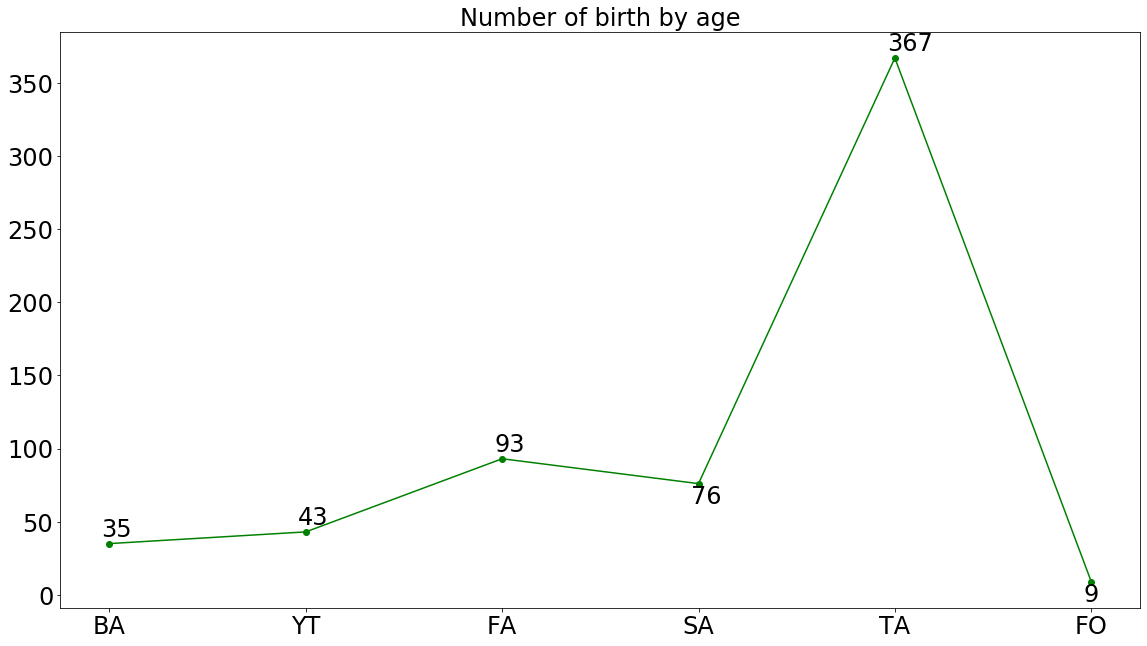

In [13]:
birth_counts = chars.groupby(['birth_era']).size().reset_index(name='size')
birth_counts.sort_values('size', ascending = False).head(10)

fig = plt.figure(figsize=(15,8))

ax = fig.add_axes([0,0,1,1])

d = birth_counts.set_index('birth_era').to_dict()['size']

ax.set_title('Number of birth by age')

ages = ['BA', 'YT', 'FA', 'SA', 'TA', 'FO']
data = [d[age] for age in ages]

for i, v in enumerate(data):
    if i == 3 or i == 5:
        ax.text(i - 0.04, v - 14, str(v))
    else:
        ax.text(i - 0.04, v + 5, str(v))
        
        
ax.plot(ages, data, 'go-')
#plt.savefig(os.path.join('birth_age.png'), dpi=300, format='png', bbox_inches='tight')

plt.show()

**Playing & showing some facts from data**

Battle of the Pelennor Fields is at March 15, 3019. Let's see who has died in this battle.

In [14]:
chars[(chars.death.str.contains('3019', na=False)) & \
      (chars.death.str.contains('March', na=False)) & \
      (chars.death.str.contains('15', na=False))][['name', 'birth', 'death']]

,name,birth,death
59,Fastred (Pelennor Fields),TA,"March 15 ,3019"
164,Horn,"Possibly late ,TA","March 15 ,TA 3019"
222,Dúnhere,TA,"March 15 ,3019"
226,Déorwine,TA,"March 15 ,3019"
260,Hirluin,TA,"March 15 ,3019"
266,Herubrand,TA,"March 15 ,3019"
269,Herefara,TA,"March 15 ,3019"
277,Harding,TA,"March 15 ,3019"
291,Halbarad,TA 2916,"March 15 ,3019"
314,Denethor II,TA 2930,"March 15 ,3019"


Getting information about some key characters

In [15]:
chars[chars.name == 'Gandalf']

,birth,death,gender,hair,height,name,race,realm,spouse,birth_era,death_era
667,BA,"January 253019 ,Battle of the Peak immortal",Male,"Grey, later white",NaN,Gandalf,Maiar,NaN,NaN,BA,Ja


In [16]:
chars[chars.name == 'Frodo Baggins']

,birth,death,gender,hair,height,name,race,realm,spouse,birth_era,death_era
819,"22 September ,TA 2968","Unknown (Last sighting ,September 29 ,3021,) (...",Male,Brown,"1.06m (3'6"")",Frodo Baggins,Hobbit,NaN,NaN,22,Unknown


In [17]:
chars[chars.name.str.startswith('Samwise Gamgee')]

,birth,death,gender,hair,height,name,race,realm,spouse,birth_era,death_era
669,"April 6 ,2980","Still alive, after going to the ,Undying Lands...",Male,Blond (movie),"1.22m (4'0"")",Samwise Gamgee,Hobbit,NaN,Rosie Cotton,Ap,St


In [18]:
chars[chars.name == 'Aragorn II Elessar']

,birth,death,gender,hair,height,name,race,realm,spouse,birth_era,death_era
873,"March 1 ,2931",FO 120,Male,Dark,"198cm (6'6"")",Aragorn II Elessar,Men,"Reunited Kingdom,Arnor,Gondor",Arwen,Ma,FO


# Analysis of script dataset

In [19]:
script = pd.read_csv(data_path + "/lotr_scripts.csv")
script.head()

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


This data seems cleaner than previous data we analyze. The only can be done to drop unnecessary index column.

In [20]:
script.drop('Unnamed: 0', axis = 1, inplace = True)
script.head()

,char,dialog,movie
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,DEAGOL,Arrghh!,The Return of the King
3,SMEAGOL,Deagol!,The Return of the King
4,SMEAGOL,Deagol!,The Return of the King


First, we groupby data based on character name, and see how many quotes they have in the data.

In [21]:
#remove additional blanks
script.char = script.char.str.strip()
# there are some dialogs where char is mentioned as character + VOICE OVER(or VOICEOVER)
script.char = script.char.str.replace("VOICE", "")
script.char = script.char.str.replace("OVER", "").str.strip()

char_count = script.groupby('char').size().reset_index(name='size')
top_chars = char_count.sort_values('size', ascending = False).head(4)
top_chars

,char,size
26,FRODO,229
75,SAM,218
33,GANDALF,214
2,ARAGORN,187


After getting the stats about the characters, for second step, we want to get, how many movies are there in data, and
analyze how many quotes each movie has.

In [22]:
script.movie = script.movie.str.strip()
movie_count = script.groupby('movie').size().reset_index(name='size')
movie_count.sort_values('size', ascending = False).head()

,movie,size
2,The Two Towers,1010
1,The Return of the King,873
0,The Fellowship of the Ring,507


In [23]:
#get some stats about races with grouping
two_towers_counts = script[(script.movie == 'The Two Towers') & (script.char.isin(top_chars.char.values))].groupby('char').size().reset_index(name='Size')
two_towers_counts.sort_values('Size', ascending = False)
#get some stats about races with grouping
return_of_king_counts = script[(script.movie == 'The Return of the King') & (script.char.isin(top_chars.char.values))].groupby('char').size().reset_index(name='Size')
return_of_king_counts.sort_values('Size', ascending = False)

fellowship_of_ring_counts = script[(script.movie == 'The Fellowship of the Ring') & (script.char.isin(top_chars.char.values))].groupby('char').size().reset_index(name='Size')
return_of_king_counts.sort_values('Size', ascending = False)

all_movies = two_towers_counts
all_movies['The Return of the King'] = return_of_king_counts.Size
all_movies['The Fellowship of the Ring'] = fellowship_of_ring_counts.Size
all_movies['The Two Towers'] = two_towers_counts.Size
all_movies['Total'] = two_towers_counts.Size + return_of_king_counts.Size + fellowship_of_ring_counts.Size

#all_movies.drop('Size', axis = 1, inplace=True)
all_movies

,char,Size,The Return of the King,The Fellowship of the Ring,The Two Towers,Total
0,ARAGORN,99,61,27,99,187
1,FRODO,84,74,71,84,229
2,GANDALF,47,94,73,47,214
3,SAM,89,91,38,89,218


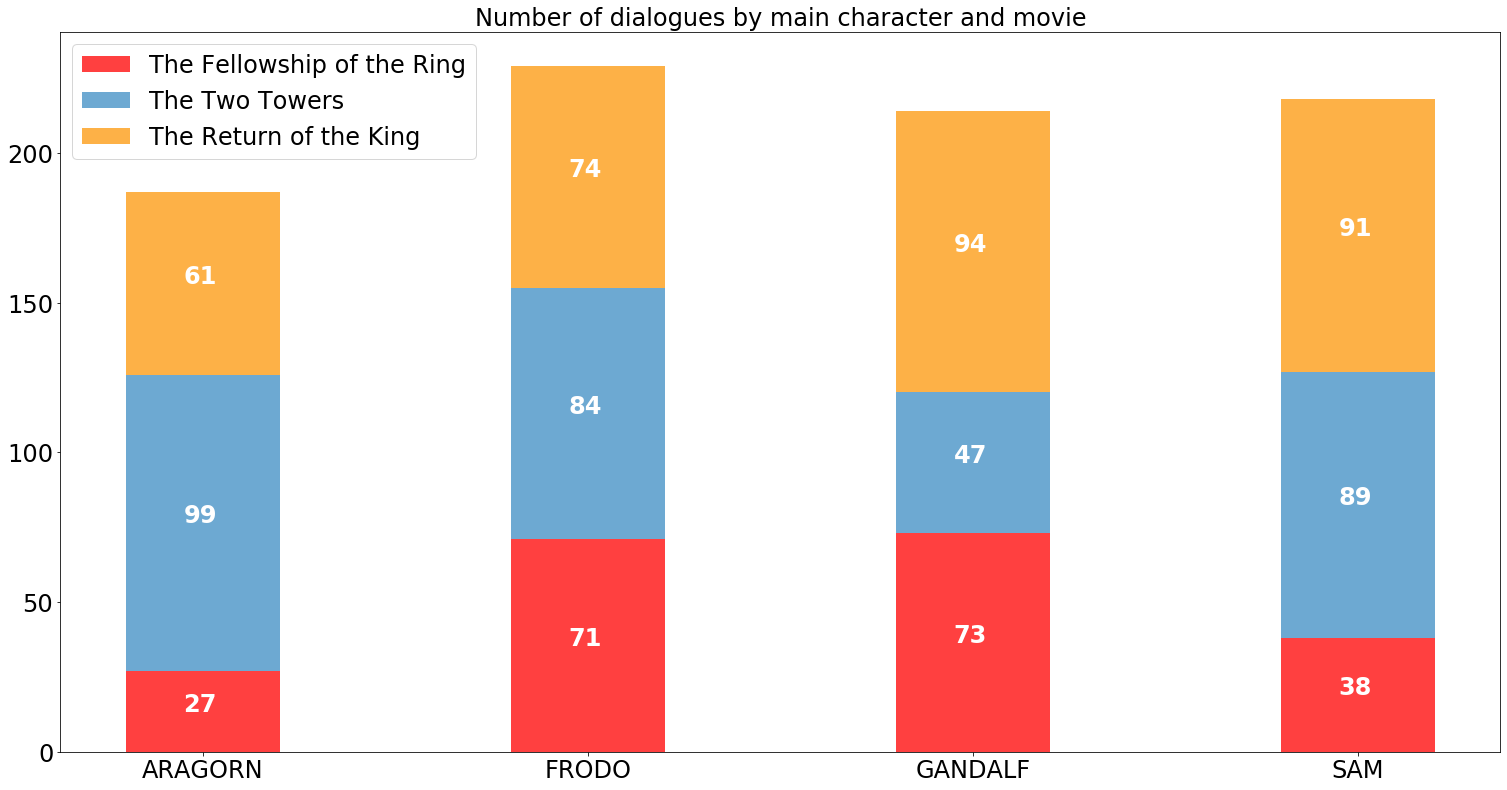

In [24]:
y_pos = np.arange(4)

char_name = all_movies.char
m2 = all_movies['The Two Towers'].values
m1 = all_movies['The Fellowship of the Ring'].values
m3 = all_movies['The Return of the King'].values

fig = plt.figure(figsize=(20,10))

width = 0.4

def sumzip(*items):
    return [sum(values) for values in zip(*items)]

ax = fig.add_axes([0,0,1,1])
ax.bar(y_pos, m1, width, color='#ff4040')
ax.bar(y_pos, m2, width,bottom=m1, color='#6da9d2')
ax.bar(y_pos, m3, width,bottom=sumzip(m1,m2), color='#fdb147')
ax.set_title('Number of dialogues by main character and movie')


for i, v in enumerate(m1):
    ax.text(i - .05, v / 2, str(v), color='white', fontweight='bold')

for i, v in enumerate(m2):
    ax.text(i - .05, m1[i] + v / 2, str(v), color='white', fontweight='bold')
    
for i, v in enumerate(m3):
    ax.text(i - .05, m1[i] + m2[i] + v / 2, str(v), color='white', fontweight='bold')

plt.xticks(y_pos, char_name)
ax.legend(labels=['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King'])

plt.savefig(os.path.join('character_movie_dialogue.png'), dpi=300, format='png', bbox_inches='tight')

plt.show()

For analyzing the dialogues, we first started with getting most used words, so we split each dialogue into the words, and remove the stopwords, then visualize them in horizontal bar chart.

In [25]:
with open(data_path + '/stopwords.txt', 'r') as f:
    stopwords = f.read().split(' ')

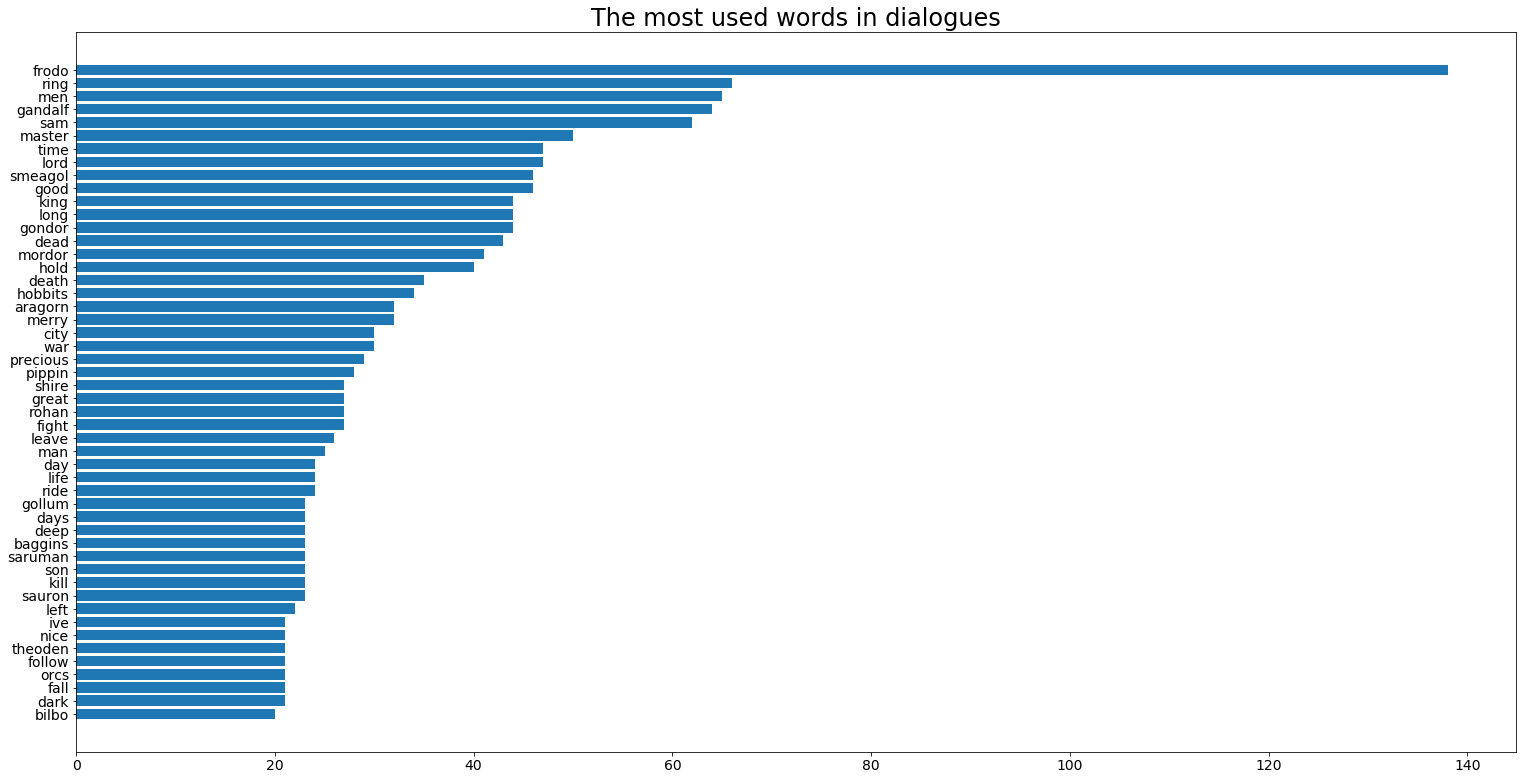

In [26]:
all_dialogue = script.dialog.str.strip().str.lower().str.replace(r'([^\s\w]|_)+', '').str.split().values
all_words = {}
for dialogue in all_dialogue:
    if type(dialogue) == list:
        for word in dialogue:
            if word not in stopwords:
                if word not in all_words:
                    all_words[word] = 1
                else:
                    all_words[word] += 1
cooccurences_all = {k: v for k, v in sorted(all_words.items(), key=lambda item: -item[1])}
keys = list(cooccurences_all.keys())[:50]
values = list(cooccurences_all.values())[:50]

# plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

fig = plt.figure(figsize=(20,10))

ax = fig.add_axes([0,0,1,1])

y_pos = np.arange(50)

plt.barh(y_pos, values)

ax.set_title('The most used words in dialogues')

ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.invert_yaxis()

Let's see which characters are most talkative:

In [27]:
movie_names = movie_count['movie'].values

words_count = script
words_count['word_count'] = words_count.dialog.str.split(' ').str.len()
words_count = words_count.groupby(['char','movie']).sum().astype(int).reset_index()
words_count.sort_values('word_count', ascending = False).head()

,char,movie,word_count
52,GANDALF,The Return of the King,1872
11,BILBO,The Fellowship of the Ring,1491
115,SAM,The Return of the King,1440
51,GANDALF,The Fellowship of the Ring,1426
116,SAM,The Two Towers,1323


Now let's look the most talkative characters for each movie

In [28]:
for movie_name in movie_names:
    movie_characters = words_count.loc[words_count['movie'] == movie_name]
    display(movie_characters.sort_values('word_count', ascending = False).head())

,char,movie,word_count
11,BILBO,The Fellowship of the Ring,1491
51,GANDALF,The Fellowship of the Ring,1426
39,FRODO,The Fellowship of the Ring,658
43,GALADRIEL,The Fellowship of the Ring,638
13,BOROMIR,The Fellowship of the Ring,457


,char,movie,word_count
52,GANDALF,The Return of the King,1872
115,SAM,The Return of the King,1440
40,FRODO,The Return of the King,1032
105,PIPPIN,The Return of the King,848
3,ARAGORN,The Return of the King,818


,char,movie,word_count
116,SAM,The Two Towers,1323
53,GANDALF,The Two Towers,1024
63,GOLLUM,The Two Towers,935
137,THEODEN,The Two Towers,930
4,ARAGORN,The Two Towers,881


It would also be interesting to know which words main characters used most. So, in order to that, we retrieve all the dialogues the character has, and split each dialogue to words and remove stopwords.

Additionally, we add an option to find that which other characters the character mention or refer most. Basically, for each word we check that this word is inside the character list. 

In [29]:
def most_used_words(char_name, movie_name, n_words, only_characters = False):
    char_name = char_name.upper()
    m = script[script.movie == movie_name]
    w = m[m.char == char_name].dialog.str.strip().str.lower().str.replace(r'([^\s\w]|_)+', '').str.split().values
    d = {}
    for quote in w:
        for word in quote:
            if word not in stopwords and (only_characters == False or word in m.char.str.lower().values):
                if word in d:
                    d[word] += 1
                else:
                    d[word] = 1
    cooccurences = {k: v for k, v in sorted(d.items(), key=lambda item: -item[1])}
    return list(cooccurences.items())[:n_words]

Let's play with data to see what one of the main characters of each movie speak most.

In [30]:
print('Gollum in "The Two Towers"')
print("1. Most used words: \n", most_used_words('gollum', 'The Two Towers', 4))
print("2. Most mentioned character names: \n", most_used_words('gollum', 'The Two Towers', 4, only_characters=True))

Gollum in "The Two Towers"
1. Most used words: 
 [('master', 13), ('precious', 9), ('kill', 6), ('gollum', 6)]
2. Most mentioned character names: 
 [('gollum', 6), ('smeagol', 5)]


So we can discover famous words of Gollum such as 'master' and 'precious' in data  :D 

In [31]:
print('Gandalf in "The Return of the King"')
print("1. Most used words: \n", most_used_words('gandalf', 'The Return of the King', 5))
print("2. Most mentioned character names: \n", most_used_words('gandalf', 'The Return of the King', 5, only_characters=True))

Gandalf in "The Return of the King"
1. Most used words: 
 [('city', 10), ('frodo', 8), ('king', 7), ('peregrin', 7), ('gondor', 7)]
2. Most mentioned character names: 
 [('frodo', 8), ('saruman', 5), ('sauron', 5), ('faramir', 5), ('denethor', 4)]


In [32]:
print('Frodo in "The Fellowship of the Ring"')
print("1. Most used words: \n", most_used_words('frodo', 'The Fellowship of the Ring', 3))
print("2. Most mentioned character names: \n", most_used_words('frodo', 'The Fellowship of the Ring', 3, only_characters=True))

Frodo in "The Fellowship of the Ring"
1. Most used words: 
 [('sam', 7), ('bilbo', 6), ('gandalf', 5)]
2. Most mentioned character names: 
 [('sam', 7), ('bilbo', 6), ('gandalf', 5)]


So, it seems Frodo loves Sam, Bilbo, and Gandalf so much.

# Analysis of timeline of events datasets

We have a seperate set for each of six ages. Each of the sets has the year and event column. First of all, we have decided to get how many years each age lasted. Because of lack of information in data, we ignore the Fourth Age.

In [33]:
timeline_data_path = data_path + 'timeline_lotr/'

ages = {'YL' : 'Valian Year', 'YT': 'Year of the Trees', 'FA':'F.A.', 'SA':'S.A.', 'TA':'T.A.', 'FO':'Fo.A.'}
ages_original = ['The Years of Lamps', 'The Years of Trees', 'The First Age', 'The Second Age', 'The Third Age', 'The Fourth Age']


In [34]:
for i, age in enumerate(list(ages.keys())):
    print(ages_original[i], ": ")
    data = pd.read_csv(timeline_data_path + age + '.csv')
    display(data.head())

The Years of Lamps : 


,Valian Year,Calculated Sun Years,Event
0,1–1499,"1-14,363",The First War and the Marring of Arda.
1,1500,"14,373",Tulkas enters Eä and Melkor flees.
2,1900,"18,206",The completion of Arda. The Valar create the T...
3,3400,"32,579",Tulkas weds Nessa.Melkor secretly returns to A...
4,3450,"33,058",Melkor overthrows the Two Lamps forming Helcar...


The Years of Trees : 


,Year of the Trees,Calculated Sun Years,Event
0,Pre-1000,Pre-9582,Melkor sleeps in Utumno. Oromë hunts througho...
1,????,????,About some time before the waking of the Elves...
2,1000,9582,"The Valar hold council, for Yavanna and Oromë ..."
3,1050,"10,061",Varda forms the Valacirca. The first 144 Elves...
4,????,????,Spies of Melkor discover the Elves and afflict...


The First Age : 


,F.A.,Event
0,1,Men awake in Hildórien.
1,2,The host of Fingolfin camps beside Lake Mithrim.
2,5,"Fingon rescues Maedhros from Thangorodrim, Fin..."
3,6,Thingol grants permission for the Noldor to oc...
4,7,The Noldor hold a council. The Sons of Fëanor ...


The Second Age : 


,S.A.,Event
0,1,"Foundation of the Grey Havens, and of Lindon."
1,32,"The Edain, and a few Drúedain, reach Númenor; ..."
2,c. 40,Dwarves of the Firebeards and Broadbeams clans...
3,61,"Birth of Vardamir Nólimon, second King of Núme..."
4,c. 82,The emigration of the Edain to Númenor ends.


The Third Age : 


,T.A.,Event
0,2,Isildur plants a Sapling of the White Tree in ...
1,3,Ohtar brings the Shards of Narsil to Imladris.
2,10,"Valandil, at the age of 21, becomes the third ..."
3,48,Birth of Eärendil of Gondor.
4,87,Birth of Eldacar of Arnor.


The Fourth Age : 


,Fo.A.,S.R.,Events
0,1,1422,The Fourth Age begins in the reckoning of the ...
1,2,1423,Death of Adelard Took.[2] Birth of Frodo Gardn...
2,4,1425,Birth of Rose Gardner.[3]
3,6,1427,Will Whitfoot resigns and Samwise is elected M...
4,7,1428,Death of Gaffer Gamgee.[3]


<BarContainer object of 5 artists>

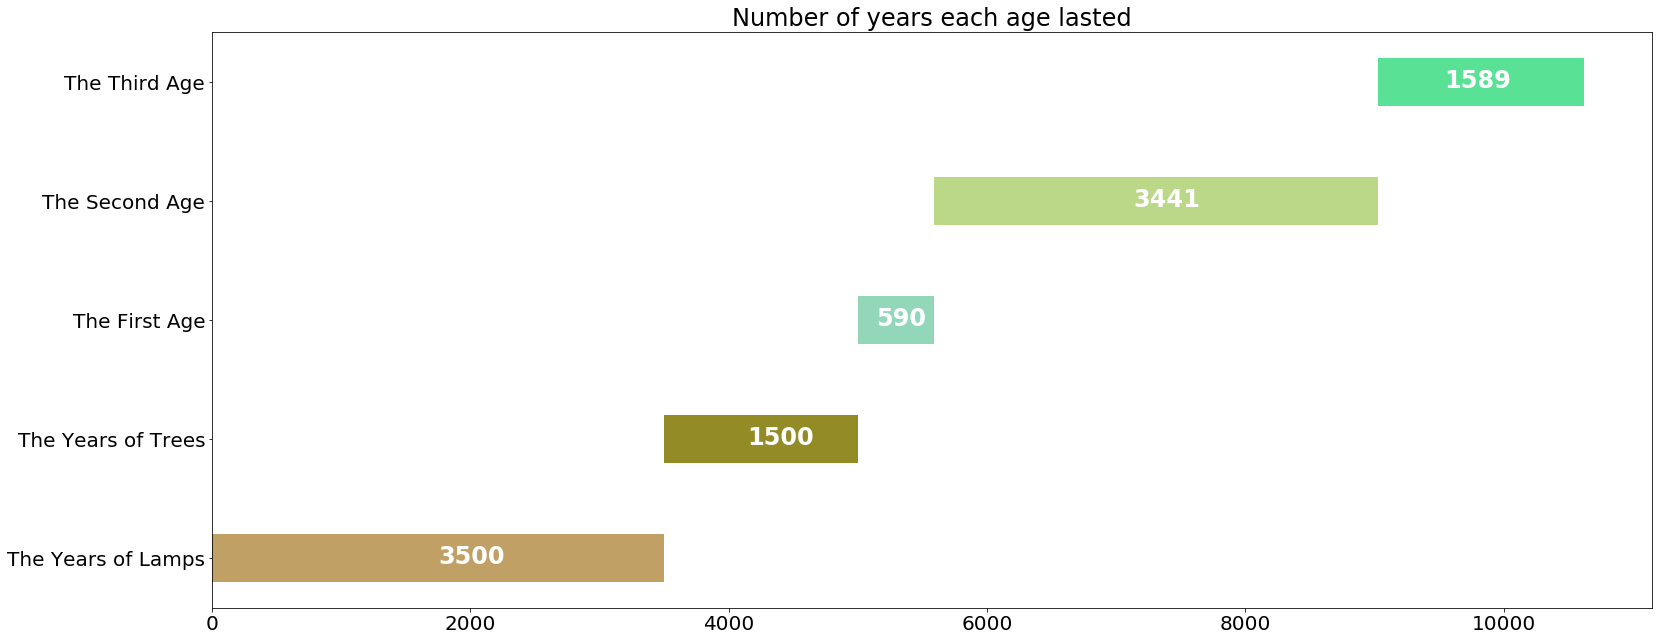

In [35]:
begin = []
end = []
curr_sum = 0
for age in list(ages.keys())[:-1]:
    data = pd.read_csv(timeline_data_path + age + '.csv')
    if age == 'YL':
        years = int(re.sub(r'([^\s\w]|_)+', ' ', data.iloc[-1][ages[age]]).split(' ')[1])
    elif age == 'SA':
        years = int(re.sub(r'([^\s\w]|_)+', '', data.iloc[-1][ages[age]]))
    else:
        years = int(data.iloc[-1][ages[age]])
    begin.append(curr_sum)
    end.append(curr_sum + years)
    curr_sum += years

begin = np.array(begin)
end = np.array(end)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)   

fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([0,0,1,1])

ax.set_yticks(range(len(begin)))

for i, v in enumerate(end):
    ax.text(end[i] - (end[i] - begin[i]) / 2 - begin[i] / 32, i - .05, str(end[i]-begin[i]), color='white', fontweight='bold')

ax.set_title('Number of years each age lasted')

ax.set_yticklabels(labels=['The Years of Lamps', 'The Years of Trees', 'The First Age', 'The Second Age', 'The Third Age'])
    
ax.barh(range(len(begin)), end-begin, left=begin, height = 0.4, color = np.random.rand(5,3))

It would be also interesting to look what are the first and last events happened in each age.

In [36]:
for i, age in enumerate(list(ages.keys())):
    print(ages_original[i], ":")
    data = pd.read_csv(timeline_data_path + age + '.csv')
    if 'Event' not in data.columns:
        print('First event: ', data.iloc[0].Events)
        print('Last event: ', data.iloc[-1].Events)
    else:
        print('First event: ', data.iloc[0].Event)
        print('Last event: ', data.iloc[-1].Event)
    print()

The Years of Lamps :
First event:  The First War and the Marring of Arda.
Last event:  The Valar raise the Pelóri and settle in Aman. The Two Trees are grown in Valinor.

The Years of Trees :
First event:  Melkor sleeps in Utumno.  Oromë hunts throughout Middle-earth. Melkor raises the Hithaeglir to hinder his efforts.
Last event:  Creation of Moon and Sun. The host of the Noldor finishes crossing the Helcaraxë and enters Beleriand under Fingolfin. Battle of the Lammoth and death of Argon. The Moon rises and after seven times, the Sun follows.

The First Age :
First event:  Men awake in Hildórien.
Last event:  Morgoth thrust from Arda. Host of Valinor departs Middle-earth.

The Second Age :
First event:  Foundation of the Grey Havens, and of Lindon.
Last event:  Deaths of Ereinion Gil-galad and Elendil; defeat of Sauron.

The Third Age :
First event:  Isildur plants a Sapling of the White Tree in Minas Anor.Death of Isildur - and his sons Elendur, Aratan and Ciryon - in the Disaster of

For other analysis, we can also merge them, and store as a one file. 

In [37]:
for i, age in enumerate(list(ages.keys())):
    data = pd.read_csv(timeline_data_path + age + '.csv')
    tmp = pd.DataFrame()
    tmp['date'] = data[ages[age]]
    if 'Event' not in data.columns:
        tmp['event'] = data['Events']
    else:
        tmp['event'] = data['Event']
    tmp['age'] = age

    if i == 0:
        merged = tmp
    else:
        merged = merged.append(tmp)

merged.head()
#merged.to_csv(data_path + '/timeline_merged.csv', index=False)

,date,event,age
0,1–1499,The First War and the Marring of Arda.,YL
1,1500,Tulkas enters Eä and Melkor flees.,YL
2,1900,The completion of Arda. The Valar create the T...,YL
3,3400,Tulkas weds Nessa.Melkor secretly returns to A...,YL
4,3450,Melkor overthrows the Two Lamps forming Helcar...,YL


As an example for event analysis, we can search events based on the battle or war.

In [38]:
merged[(merged.event.str.contains('Battle'))|(merged.event.str.contains('War'))]

,date,event,age
0,1–1499,The First War and the Marring of Arda.,YL
7,1090,Valar make war on Melkor in the War for Sake o...,YT
51,1497,"First Battle of Beleriand. Death of Denethor, ...",YT
53,1500,Creation of Moon and Sun. The host of the Nold...,YT
9,60,"Dagor Aglareb (""The Glorious Battle""), Siege o...",FA
46,375,Battle of the Gelion-Ascar Stockade. Deaths of...,FA
56,402,Battle of Aglon Pass.,FA
80,455,"Morgoth breaks the Siege of Angband, Dagor Bra...",FA
96,472,"Nirnaeth Arnoediad (""Battle of Unnumbered Tear...",FA
108,495,"Battle of the Crossings of the Taeglin, Battle...",FA
